In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("/content/athlete_events.csv")

In [3]:
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [4]:
df.info
df.shape

(271116, 15)

In [5]:
df.isnull().sum()

,0
ID,0
Name,0
Sex,0
Age,9474
Height,60171
Weight,62875
Team,0
NOC,0
Games,0
Year,0


In [6]:
noc=pd.read_csv("/content/noc_regions.csv")

In [7]:
df=df.merge(noc,how="left",on="NOC")
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN


In [8]:
df.isnull().sum()

,0
ID,0
Name,0
Sex,0
Age,9474
Height,60171
Weight,62875
Team,0
NOC,0
Games,0
Year,0


# Data Cleaning:

In [9]:
#medals:
df['has_medal'] = df['Medal'].notna().astype(int)
df = df.drop(columns=['Medal'])
df.isnull().sum()

,0
ID,0
Name,0
Sex,0
Age,9474
Height,60171
Weight,62875
Team,0
NOC,0
Games,0
Year,0


In [10]:
df=df.drop(columns=["notes"])

In [11]:
df['region'] = df['region'].fillna(df['NOC'])

In [12]:
# Impute Age — median per Sport and Sex
df['Age'] = df.groupby(['Sport', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
df.isnull().sum()

,0
ID,0
Name,0
Sex,0
Age,0
Height,60171
Weight,62875
Team,0
NOC,0
Games,0
Year,0


In [13]:
df['Height'] = df.groupby(['Sport', 'Sex'])['Height'].transform(lambda x: x.fillna(x.median()))
df['Weight']= df.groupby(['Sport', 'Sex'])['Weight'].transform(lambda x: x.fillna(x.median()))
df.isnull().sum()

,0
ID,0
Name,0
Sex,0
Age,0
Height,100
Weight,595
Team,0
NOC,0
Games,0
Year,0


In [14]:
df.dropna(inplace=True)

In [15]:
df.duplicated().sum()
# we won't drop duplicates as one athlete can participate more than once in a competiton

np.int64(1255)

# EDA:

In [16]:
!pip install plotly==5.24.1 kaleido==0.2.1 --quiet

import kaleido
print(kaleido.__version__)          # should print 0.2.1

0.2.1


In [17]:
import kaleido

In [18]:
medal_counts = df['has_medal'].value_counts(normalize=True) * 100
print("\nMedal Distribution (%):\n", medal_counts.round(2))
# medal winners vs non winners:
fig = px.pie(medal_counts.reset_index(), values='proportion', names='has_medal',
             title='Medal Winners vs. Non-Winners ',
             color_discrete_sequence=['lightgray', 'gold'])
fig.update_traces(pull=[0, 0.2])  # Explode medal slice
fig.update_layout(
    width=550,
    height=550
)
fig.show()
fig.write_image("medalwinnersvsnonwinners.png", scale=2, width=1000, height=600)


Medal Distribution (%):
 has_medal
0    85.36
1    14.64
Name: proportion, dtype: float64


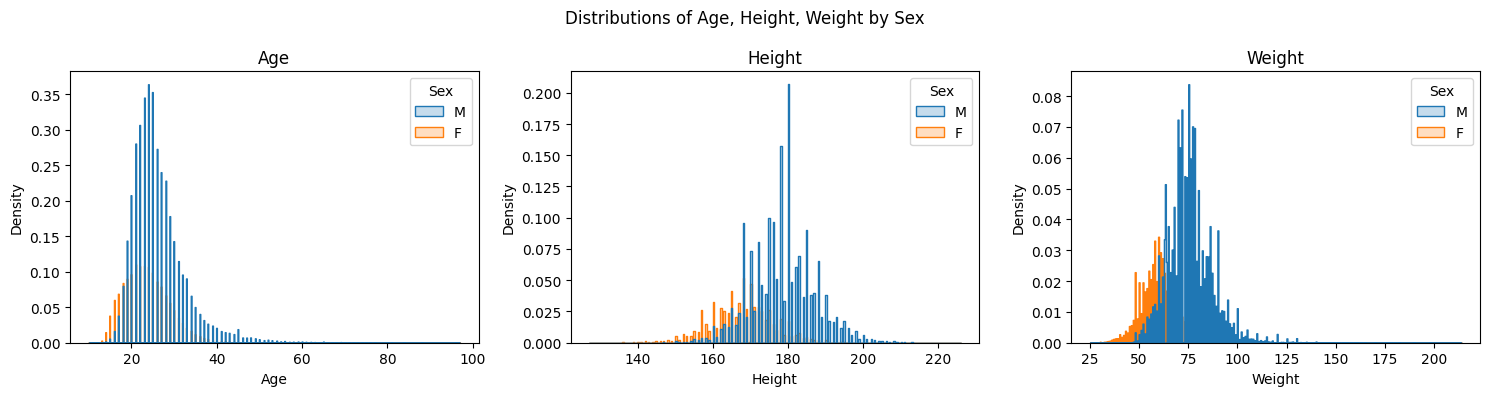

<Figure size 640x480 with 0 Axes>

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['Age', 'Height', 'Weight']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(num_cols):
    sns.histplot(
        data=df,
        x=col,
        hue='Sex',
        kde=False,
        element='step',
        stat='density',
        ax=axes[i]
    )
    axes[i].set_title(col)

plt.suptitle('Distributions of Age, Height, Weight by Sex')
plt.tight_layout()
plt.show()
plt.savefig("disofage,height,weightbysex.png")

In [20]:
import plotly.express as px

def bar_with_labels(data, x, y, title, color=None, color_map=None, rotate=False):
    fig = px.bar(
        data, x=x, y=y, title=title,
        color=color, color_discrete_map=color_map,
        text=y
    )
    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.update_layout(xaxis_tickangle=-45 if rotate else 0)
    fig.show()
    return fig


fig1 = bar_with_labels(
    df['Sex'].value_counts().reset_index(),
    x='Sex', y='count',
    title='Athlete Count by Sex',
    color='Sex',
    color_map={'M': 'blue', 'F': 'pink'}
)

fig2 = bar_with_labels(
    df['Season'].value_counts().reset_index(),
    x='Season', y='count',
    title='Events by Season',
    color='Season',
    color_map={'Summer': 'orange', 'Winter': 'lightblue'}
)

top_sports = df['Sport'].value_counts().nlargest(10).reset_index()
fig3 = bar_with_labels(
    top_sports,
    x='Sport', y='count',
    title='Top 10 Sports by Participation',
    rotate=True
)

top_regions = df['region'].value_counts().nlargest(10).reset_index()
fig4 = bar_with_labels(
    top_regions,
    x='region', y='count',
    title='Top 10 Countries by Athletes',
    rotate=True
)


df_sample = df[
    df['region'].isin(top_regions['region']) &
    df['Sport'].isin(top_sports['Sport'])
]

fig5 = px.sunburst(
    df_sample,
    path=['region', 'Sport'],
    values='ID',
    title='Athlete Distribution: Country → Sport'
).update_traces(textinfo='label+value')

fig5.show()


figs = {
    "athlete_count_by_sex.png": fig1,
    "events_by_season.png": fig2,
    "top_10_sports_participation.png": fig3,
    "top_10_countries_athletes.png": fig4,
    "athlete_distribution_country_sport.png": fig5,
}

for name, fig in figs.items():
    fig.write_image(name, scale=2, width=1000, height=600)

In [21]:
# Athletes per year, faceted by Sex
athletes_year = df.groupby(['Year', 'Sex'])['ID'].nunique().reset_index(name='Unique Athletes')
fig = px.line(athletes_year, x='Year', y='Unique Athletes', color='Sex',
              title='Unique Athletes Over Time by Sex (Gender Evolution)',
              color_discrete_map={'M': 'blue', 'F': 'pink'})
fig.show()

# Medals per year
medals_year = df[df['has_medal'] == 1].groupby('Year')['has_medal'].count().reset_index()
fig2 = px.line(medals_year, x='Year', y='has_medal', title='Total Medals Awarded Over Time',
               markers=True, line_shape='spline')  # Smooth spline for creativity
fig2.show()
fig1.write_image("athletes_per_year.png", scale=2, width=1000, height=600)
fig2.write_image("medals_per_year.png", scale=2, width=1000, height=600)


In [22]:
import plotly.express as px


medal_rate_sex = df.groupby('Sex')['has_medal'].mean().reset_index()
medal_rate_season = df.groupby('Season')['has_medal'].mean().reset_index()

def pct_bar(df, x, y, title, color, color_map):
    fig = px.bar(
        df, x=x, y=y, title=title,
        color=color, color_discrete_map=color_map,
        text=y
    )
    fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
    fig.update_layout(yaxis_tickformat='%')
    fig.show()
    return fig

fig1 = pct_bar(
    medal_rate_sex,
    x='Sex', y='has_medal',
    title='Medal Win Rate by Sex',
    color='Sex',
    color_map={'M': 'blue', 'F': 'pink'}
)

fig2 = pct_bar(
    medal_rate_season,
    x='Season', y='has_medal',
    title='Medal Win Rate by Season',
    color='Season',
    color_map={'Summer': 'orange', 'Winter': 'lightblue'}
)


In [23]:
import plotly.express as px
import pandas as pd

avg_by_sport = (
    df.groupby('Sport')[['Age', 'Height', 'Weight']]
      .mean()
      .nlargest(10, 'Age')
      .reset_index()
)

avg_melt = avg_by_sport.melt(
    id_vars='Sport',
    value_vars=['Age', 'Height', 'Weight']
)

fig1 = px.bar(
    avg_melt,
    x='Sport',
    y='value',
    color='variable',
    barmode='group',
    title='Average Age, Height, Weight for Top 10 Sports (by Avg Age)',
    text='value'
)

fig1.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig1.update_layout(xaxis_tickangle=-45)

fig1.write_image(
    "avg_age_height_weight_top10_sports.png",
    scale=2, width=1200, height=600
)
fig1.show()


country_perf = (
    df.groupby('region')
      .agg(
          Total_Athletes=('ID', 'nunique'),
          Total_Medals=('has_medal', 'sum'),
          Win_Rate=('has_medal', 'mean')
      )
      .nlargest(20, 'Total_Medals')
      .reset_index()
)

fig2 = px.treemap(
    country_perf,
    path=['region'],
    values='Total_Athletes',
    color='Win_Rate',
    color_continuous_scale='Greens',
    title='Top Countries: Size by Athletes, Color by Win Rate',
    custom_data=['Total_Athletes', 'Total_Medals', 'Win_Rate']
)

fig2.update_traces(
    texttemplate=(
        "<b>%{label}</b><br>"
        "Athletes: %{customdata[0]}<br>"
        "Medals: %{customdata[1]}<br>"
        "Win rate: %{customdata[2]:.1%}"
    )
)

fig2.write_image(
    "top_countries_athletes_medals_winrate.png",
    scale=2, width=900, height=700
)
fig2.show()


In [24]:
#download all images:
from google.colab import files
import zipfile
import os

IMAGE_DIR = "."

zip_name = "EDAimages.zip"

with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".png"):
            zipf.write(os.path.join(IMAGE_DIR, file))

files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature Engineering:

In [25]:
df["Games"].unique()


array(['1992 Summer', '2012 Summer', '1920 Summer', '1900 Summer',
       '1988 Winter', '1992 Winter', '1994 Winter', '1932 Summer',
       '2002 Winter', '1952 Summer', '1980 Winter', '2000 Summer',
       '1996 Summer', '1912 Summer', '1924 Summer', '2014 Winter',
       '1948 Summer', '1998 Winter', '2006 Winter', '2008 Summer',
       '2016 Summer', '2004 Summer', '1960 Winter', '1964 Winter',
       '1984 Winter', '1984 Summer', '1968 Summer', '1972 Summer',
       '1988 Summer', '1936 Summer', '1952 Winter', '1956 Winter',
       '1956 Summer', '1960 Summer', '1928 Summer', '1976 Summer',
       '1980 Summer', '1964 Summer', '2010 Winter', '1968 Winter',
       '1906 Summer', '1972 Winter', '1976 Winter', '1924 Winter',
       '1904 Summer', '1928 Winter', '1908 Summer', '1948 Winter',
       '1932 Winter', '1936 Winter', '1896 Summer'], dtype=object)

In [26]:
#since we have year and season columns, no need for Games column as it doesn't add any new info
df.drop(columns=["Games"],inplace=True)
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,region,has_medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,China,0


In [27]:
#BMI:
df["BMI"]=df["Weight"]/((df["Height"]/100)**2)
df["BMI"]=df["BMI"].round(1)
# Age groups:
bins = [0, 18, 23,28,33,100]
labels = ['<18', '18-23', '24-28', '29-33', '34+']
df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
#Is Team sport ?
team_sports = [
    'Basketball', 'Football', 'Handball', 'Hockey', 'Volleyball',
    'Water Polo', 'Rowing', 'Rugby', 'Sailing', 'Baseball',
    'Softball', 'Beach Volleyball', 'Ice Hockey', 'Bobsleigh',
    'Curling', 'Canoeing', 'Equestrian', 'Archery'
]

df['Is_team_sport'] = df['Sport'].isin(team_sports).astype(int)

print("Team sport distribution:")
print(df['Is_team_sport'].value_counts(normalize=True).round(3))
df.head(2)

Team sport distribution:
Is_team_sport
0    0.762
1    0.238
Name: proportion, dtype: float64


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,region,has_medal,BMI,Age_group,Is_team_sport
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,China,0,24.7,24-28,1
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,China,0,20.8,24-28,0


In [28]:
#Experience:
first_year = df.groupby('Name')['Year'].min().to_dict()
# Is this the first participation?
df['Is_first_appearance'] = df['Year'] == df['Name'].map(first_year)
df['Is_first_appearance'] = df['Is_first_appearance'].astype(int)

# Years since first participation
df['Years_since_first'] = df['Year'] - df['Name'].map(first_year)

In [29]:
#  Number of athletes from same NOC this year
df['NOC_athletes_this_year'] = df.groupby(['NOC', 'Year'])['ID'].transform('nunique')

# Cumulative medals of NOC before this year (simple lagged version)
df_sorted = df.sort_values(['NOC', 'Year'])
df_sorted['Prev_medals_NOC'] = df_sorted.groupby('NOC')['has_medal'].cumsum().shift(1).fillna(0)
df = df_sorted.sort_index()


In [30]:
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Year,Season,...,Event,region,has_medal,BMI,Age_group,Is_team_sport,Is_first_appearance,Years_since_first,NOC_athletes_this_year,Prev_medals_NOC
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992,Summer,...,Basketball Men's Basketball,China,0,24.7,24-28,1,1,0,276,126.0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012,Summer,...,Judo Men's Extra-Lightweight,China,0,20.8,24-28,0,1,0,375,739.0


# Machine Learning:

**Athlete Medal Prediction:**

In [31]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import pickle
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Features to use (exclude identifiers and anything that could leak)
exclude = ['ID', 'Name', 'Team', 'NOC', 'City', 'Event', 'Medal']

features = [col for col in df.columns if col not in exclude + ['has_medal']]

X = df[features]
y = df['has_medal']

print("Number of features:", len(features))
print("\nTarget distribution:\n", y.value_counts(normalize=True).round(3))

Number of features: 15

Target distribution:
 has_medal
0    0.854
1    0.146
Name: proportion, dtype: float64


We excluded identifier and high-cardinality categorical variables such as ID, Name, Team, Event, and City, as they do not carry intrinsic predictive information about athletic performance and may lead to overfitting. The NOC variable was also excluded to prevent target leakage and shortcut learning, since medal outcomes are strongly correlated with country dominance. The Medal column was removed because it directly defines the target variable (has_medal). The remaining features capture physical attributes, experience, temporal context, and historical strength in a way that supports generalizable athlete-level medal prediction.

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Valid:", X_valid.shape)

Train: (216416, 15)
Valid: (54105, 15)


In [34]:
numeric = ['Age', 'Height', 'Weight', 'BMI', 'Years_since_first',
           'NOC_athletes_this_year', 'Prev_medals_NOC']

scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_valid[numeric]  = scaler.transform(X_valid[numeric])

In [35]:
#  Identify categorical columns that are still object/string/category
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

#One-hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_valid = pd.get_dummies(X_valid, columns=categorical_cols, drop_first=True)

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

print("Shape after one-hot encoding:", X_train.shape)

Categorical columns to encode: ['Sex', 'Season', 'Sport', 'region', 'Age_group']
Shape after one-hot encoding: (216416, 279)


Scaling converts features with different units into comparable standardized values, preventing large-scale variables from dominating the learning process.

In [36]:
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=1
)

print("\nTraining XGBoost...")
model.fit(X_train, y_train)


Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [37]:
# 6. Evaluation :
y_pred = model.predict(X_valid)
y_proba = model.predict_proba(X_valid)[:, 1]

print("\nResults:")
print(f"Accuracy:  {accuracy_score(y_valid, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_valid, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_valid, y_proba):.4f}")


Results:
Accuracy:  0.7578
F1-score:  0.4854
ROC AUC:   0.8495


Since the task is a binary classification problem with significant class imbalance, regression metrics such as R² or MSE are not appropriate. Model performance is therefore evaluated using F1-score as the primary metric, as it balances precision and recall and better reflects performance on the minority class (medalists). Cross-validated F1 is used to assess model stability, while ROC-AUC provides insight into each model’s ability to discriminate between medal and non-medal outcomes across thresholds. Accuracy is reported for completeness but is not used for model selection due to class imbalance.

In [38]:
with open('best_athlete_xgboost_model.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'scaler': scaler,
        'feature_names': X_train.columns.tolist(),
        'numeric_cols': numeric
    }, f)

print("Saved: best_athlete_xgboost_model.pkl")

Saved: best_athlete_xgboost_model.pkl


**Country Medal Prediction :**

In [39]:
# Group by NOC and Year
country_df = df.groupby(['NOC', 'Year', 'region', 'Season']).agg(
    total_medals = ('has_medal', 'sum'),
    num_athletes = ('ID', 'nunique'),
    avg_age = ('Age', 'mean'),
    avg_bmi = ('BMI', 'mean'),
).reset_index()

# Fill any rare NaN from averages
country_df['avg_age'] = country_df['avg_age'].fillna(country_df['avg_age'].median())
country_df['avg_bmi'] = country_df['avg_bmi'].fillna(country_df['avg_bmi'].median())

print("Country-year dataset shape:", country_df.shape)
print("\nSample:")
print(country_df.head(8))

Country-year dataset shape: (3832, 8)

Sample:
   NOC  Year       region  Season  total_medals  num_athletes    avg_age  \
0  AFG  1936  Afghanistan  Summer             0            15  24.312500   
1  AFG  1948  Afghanistan  Summer             0            25  24.120000   
2  AFG  1956  Afghanistan  Summer             0            12  25.000000   
3  AFG  1960  Afghanistan  Summer             0            12  23.312500   
4  AFG  1964  Afghanistan  Summer             0             8  22.375000   
5  AFG  1968  Afghanistan  Summer             0             5  23.200000   
6  AFG  1972  Afghanistan  Summer             0             8  27.000000   
7  AFG  1980  Afghanistan  Summer             0            11  23.636364   

     avg_bmi  
0  23.281250  
1  23.336000  
2  23.600000  
3  23.850000  
4  24.050000  
5  24.000000  
6  21.850000  
7  22.118182  


In [40]:
# Sort by NOC and Year
country_df = country_df.sort_values(['NOC', 'Year'])

# Previous medals (1 and 2 editions ago)
country_df['prev_medals_1'] = country_df.groupby('NOC')['total_medals'].shift(1).fillna(0)
country_df['prev_medals_2'] = country_df.groupby('NOC')['total_medals'].shift(2).fillna(0)

# Previous number of athletes
country_df['prev_athletes'] = country_df.groupby('NOC')['num_athletes'].shift(1).fillna(0)

#change in medals last time
country_df['medal_change_prev'] = country_df.groupby('NOC')['total_medals'].diff().fillna(0)

print("Added historical features.")
print(country_df[['NOC', 'Year', 'total_medals', 'prev_medals_1', 'prev_athletes']].head(10))

Added historical features. Sample:
   NOC  Year  total_medals  prev_medals_1  prev_athletes
0  AFG  1936             0            0.0            0.0
1  AFG  1948             0            0.0           15.0
2  AFG  1956             0            0.0           25.0
3  AFG  1960             0            0.0           12.0
4  AFG  1964             0            0.0           12.0
5  AFG  1968             0            0.0            8.0
6  AFG  1972             0            0.0            5.0
7  AFG  1980             0            0.0            8.0
8  AFG  1988             0            0.0           11.0
9  AFG  1996             0            0.0            5.0


In [41]:
# Target
y_country = country_df['total_medals']

# Features
exclude_country = ['NOC', 'Year', 'region', 'Season', 'total_medals']
X_country = country_df.drop(columns=exclude_country)

print("Features:", X_country.columns.tolist())
print("\nShape:", X_country.shape)

Features: ['num_athletes', 'avg_age', 'avg_bmi', 'prev_medals_1', 'prev_medals_2', 'prev_athletes', 'medal_change_prev']

Shape: (3832, 7)


In [43]:
# Time-aware split: train on earlier years, validate on later ones
train_mask = country_df['Year'] <= 2012
X_train_c = X_country[train_mask]
y_train_c = y_country[train_mask]

X_valid_c = X_country[~train_mask]
y_valid_c = y_country[~train_mask]

print("Train years:", sorted(country_df[train_mask]['Year'].unique()))
print("Valid years:", sorted(country_df[~train_mask]['Year'].unique()))
print(f"Train rows: {len(X_train_c)}   Valid rows: {len(X_valid_c)}")

Train years: [np.int64(1896), np.int64(1900), np.int64(1904), np.int64(1906), np.int64(1908), np.int64(1912), np.int64(1920), np.int64(1924), np.int64(1928), np.int64(1932), np.int64(1936), np.int64(1948), np.int64(1952), np.int64(1956), np.int64(1960), np.int64(1964), np.int64(1968), np.int64(1972), np.int64(1976), np.int64(1980), np.int64(1984), np.int64(1988), np.int64(1992), np.int64(1994), np.int64(1996), np.int64(1998), np.int64(2000), np.int64(2002), np.int64(2004), np.int64(2006), np.int64(2008), np.int64(2010), np.int64(2012)]
Valid years: [np.int64(2014), np.int64(2016)]
Train rows: 3536   Valid rows: 296


In [44]:
#numeric columns scaling:
numeric_country = [
    'num_athletes', 'avg_age', 'avg_bmi',
    'prev_medals_1', 'prev_medals_2', 'prev_athletes', 'medal_change_prev'
]

scaler_c = StandardScaler()
X_train_c[numeric_country] = scaler_c.fit_transform(X_train_c[numeric_country])
X_valid_c[numeric_country]  = scaler_c.transform(X_valid_c[numeric_country])

In [45]:
# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.85,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

print("Training XGBoost Regressor...")
xgb_reg.fit(X_train_c, y_train_c)

# Predict
y_pred_c = xgb_reg.predict(X_valid_c)



Training XGBoost Regressor...


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Model Evaluate
mae = mean_absolute_error(y_valid_c, y_pred_c)
rmse = np.sqrt(mean_squared_error(y_valid_c, y_pred_c))
r2 = r2_score(y_valid_c, y_pred_c)

print("\nXGBoost Results:")
print(f"MAE:   {mae:.3f}   (average error in number of medals)")
print(f"RMSE:  {rmse:.3f}")
print(f"R²:    {r2:.3f}")


XGBoost Results:
MAE:   1.223   (average error in number of medals)
RMSE:  4.992
R²:    0.963


In [48]:
with open('best_country_medal_model.pkl', 'wb') as f:
    pickle.dump({
        'model': xgb_reg,
        'scaler': scaler_c,
        'feature_names': X_train_c.columns.tolist(),
        'numeric_cols': numeric_country
    }, f)

print("Saved country medal model: best_country_medal_model.pkl")

Saved country medal model: best_country_medal_model.pkl


**Athlete Medal Prediction Model (XGBoost Classifier)**

The model predicts whether an individual athlete wins a medal in a given participation.
It achieves 76% accuracy, but due to strong class imbalance (~85% non-medalists), the more informative F1-score is 0.485.
The ROC AUC of 0.849 indicates good ranking ability — the model assigns significantly higher probabilities to actual medal winners compared to non-winners.

**Country Medal Count Prediction Model (XGBoost Regressor)**

This model forecasts the total number of medals a country wins in a given Olympic year.
It achieves very strong performance: MAE = 1.22 (average error of about 1.2 medals), RMSE = 4.99, and an excellent R² = 0.963.
An R² of 0.963 means the model explains 96.3% of the variance in actual medal counts .